In [1]:
%load_ext autoreload
%autoreload 2


In [11]:
import glob
import pandas as pd
from src.utils import map_category
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


# Define the path to the interim data directory
data_path = "data/interim/part-*.json"
json_files = glob.glob(data_path)
papers_df = pd.concat([pd.read_json(file, lines=True) for file in json_files], ignore_index=True)

papers_df["arxiv_main_category"] = papers_df["main_category"].apply(map_category)
papers_df["text"] = papers_df["title"] + "\n" + papers_df["summary"]
# papers_df = papers_df[["text", "arxiv_main_category"]]

X = papers_df["text"].tolist()
y = papers_df["arxiv_main_category"].tolist()

X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, np.arange(len(X)), test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [3]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.extmath import density
from time import time

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    weighted_f1 = f1_score(y_test, pred, average='weighted')
    print(f"Weighted F1 score:    {weighted_f1:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()
    
    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, weighted_f1, train_time, test_time


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC

results = []
for clf, name in (
    (LogisticRegression(), "Logistic Regression"),
    (RidgeClassifier(), "Ridge Classifier"),
    (KNeighborsClassifier(), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    (LinearSVC(), "Linear SVC"),
    (SGDClassifier(), "SGD Classifier"),
    (NearestCentroid(), "NearestCentroid"),
    (ComplementNB(), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))
    

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression()
train time: 1.92s
test time:  0.00185s
Weighted F1 score:    0.715
dimensionality: 8444
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier()
train time: 0.294s
test time:  0.00135s
Weighted F1 score:    0.773
dimensionality: 8444
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.0s
test time:  0.278s
Weighted F1 score:    0.759

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 4.78s
test time:  0.0479s
Weighted F1 score:    0.604

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC()
train time: 0.167s
test time:  0.0s


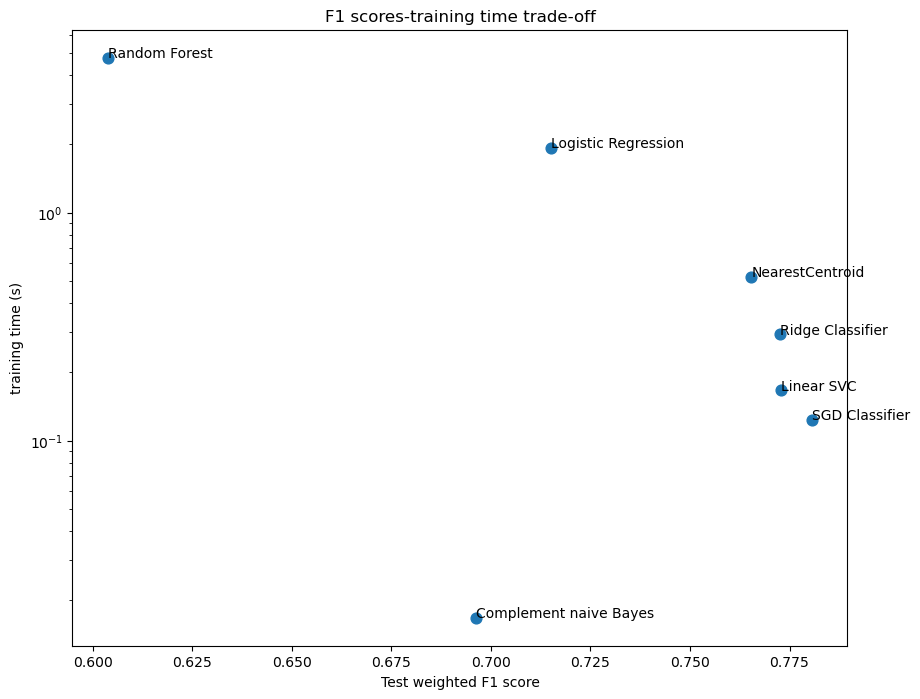

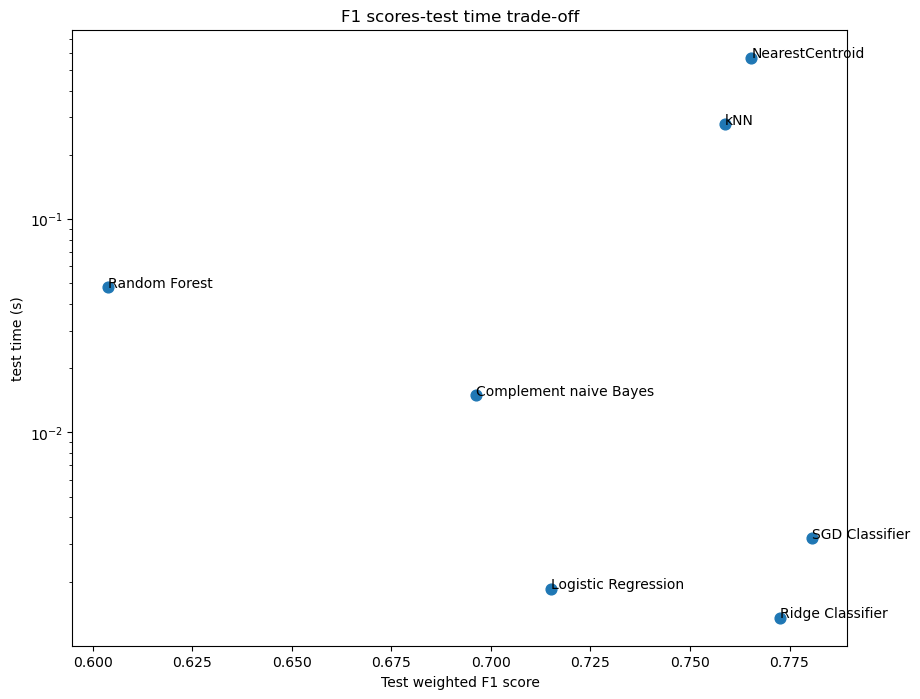

In [5]:
import numpy as np
import matplotlib.pyplot as plt  # Make sure matplotlib is imported

indices = np.arange(len(results))

# Extract all 5 elements from the results
results = [[x[i] for x in results] for i in range(4)]

# Unpack all 5 elements
clf_names, f1_scores, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(f1_scores, training_time, s=60)
ax1.set(
    title="F1 scores-training time trade-off",
    yscale="log",
    xlabel="Test weighted F1 score",
    ylabel="training time (s)",
)

fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(f1_scores, test_time, s=60)
ax2.set(
    title="F1 scores-test time trade-off",
    yscale="log",
    xlabel="Test weighted F1 score",
    ylabel="test time (s)",
)


# Add text annotations to all plots
for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (f1_scores[i], training_time[i]))
    ax2.annotate(txt, (f1_scores[i], test_time[i]))


In [ ]:
from transformers import AutoTokenizer
from adapters import AutoAdapterModel
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
model = AutoAdapterModel.from_pretrained("allenai/specter2_base")
model.to(device)  # Move model to GPU if available
model.eval()

def get_embeddings(titles, abstracts, batch_size=16):
    """
    Generate embeddings for scientific paper titles and abstracts using SPECTER2.
    
    Args:
        titles (list): List of paper titles
        abstracts (list): List of paper abstracts
        batch_size (int): Batch size for processing
        
    Returns:
        numpy.ndarray: Normalized embeddings for input papers
    """
    all_embeddings = []
    
    # Show progress bar for batch processing
    with torch.no_grad():
        for i in tqdm(range(0, len(titles), batch_size), desc="Generating embeddings"):
            batch_titles = titles[i:i+batch_size]
            batch_abstracts = abstracts[i:i+batch_size]

            # Concatenate with [SEP] token as in SPECTER2 training
            text_batch = [
                title + tokenizer.sep_token + (abstract or "")
                for title, abstract in zip(batch_titles, batch_abstracts)
            ]

            # Tokenize
            inputs = tokenizer(
                text_batch,
                padding=True,
                truncation=True,
                return_tensors="pt",
                return_token_type_ids=False,
                max_length=512
            )
            
            # Move inputs to the appropriate device
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Model forward pass
            outputs = model(**inputs)
            embeddings = F.normalize(outputs.pooler_output, p=2, dim=1)
            all_embeddings.append(embeddings.cpu())  # Move back to CPU for concatenation

    # Only concatenate if there are embeddings
    if all_embeddings:
        return torch.cat(all_embeddings, dim=0).numpy()
    else:
        return np.array([])

# Extract training and test data
print("Preparing datasets...")
ds_train = papers_df.loc[train_idx, ["title", "summary"]].rename(columns={"summary": "abstract"})
ds_test = papers_df.loc[test_idx, ["title", "summary"]].rename(columns={"summary": "abstract"})

# Generate embeddings with progress tracking
print("Generating training embeddings...")
X_train = get_embeddings(ds_train["title"].tolist(), ds_train["abstract"].tolist())
print(f"Training embeddings shape: {X_train.shape}")

print("Generating test embeddings...")
X_test = get_embeddings(ds_test["title"].tolist(), ds_test["abstract"].tolist())
print(f"Test embeddings shape: {X_test.shape}")


Preparing datasets...
Generating training embeddings...


Generating embeddings: 100%|██████████| 341/341 [24:00<00:00,  4.22s/it]


Training embeddings shape: (5442, 768)
Generating test embeddings...


Generating embeddings: 100%|██████████| 86/86 [05:57<00:00,  4.16s/it]

Test embeddings shape: (1361, 768)


In [37]:
results_embed = []
for clf, name in (
    (LogisticRegression(), "Logistic Regression"),
    (RidgeClassifier(), "Ridge Classifier"),
    (KNeighborsClassifier(), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    (LinearSVC(), "Linear SVC"),
    (SGDClassifier(), "SGD Classifier"),
    (NearestCentroid(), "NearestCentroid"),
    # (ComplementNB(), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results_embed.append(benchmark(clf, name))


Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression()
train time: 1.08s
test time:  0.006s
Weighted F1 score:    0.73
dimensionality: 768
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier()
train time: 0.0653s
test time:  0.00224s
Weighted F1 score:    0.749
dimensionality: 768
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.00833s
test time:  0.114s
Weighted F1 score:    0.796

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 16.0s
test time:  0.0219s
Weighted F1 score:    0.731

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC()
train time: 5.82s
test time:  0.0069